# Video pipeline with Yolo + Resnet Model

In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [2]:
# serieses = [116, 117, 118, 119, 120]
serieses = [127, 128, 129]

series_paths = {series: os.path.join(FINAL_RESULTS_PATH, "series", str(series)) for series in serieses}

loaders = {series: AdaptationParser(series_path=series_path, model_name="video", type_of="router_pipeline") for series, series_path in series_paths.items()}

In [3]:
loaders

{127: <experiments.utils.parser.AdaptationParser at 0x7f35fc709820>,
 128: <experiments.utils.parser.AdaptationParser at 0x7f35552a1220>,
 129: <experiments.utils.parser.AdaptationParser at 0x7f35fc672040>}

In [4]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp['0.yaml']
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 127 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 0,
    'baseline_mode': 'scale',
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10000,
    'gamma': 0,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'metadata': 'repeat of 103 to make sure about the concolusion',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 10,
    'nodes': [   {   'cpu_request': '2',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'model_variants': 'yolov5n',
                     'node_name': 'yol

In [5]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [6]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{127: False, 128: False, 129: False}

In [7]:
adaptation_logs = dict(map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items()))

In [8]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(adaptation_log=adaptation_logs[series])

## Comparing Predicted Load with the Recieved Load

[6, 5, 6, 5, 4, 4, 6, 4, 5, 5, 5, 6, 4, 6, 6, 7, 5, 5, 3, 5, 4, 5, 7, 6, 6, 7, 4, 5, 5, 5, 6, 7, 5, 5, 5, 4, 5, 6, 5, 4, 5, 4, 4, 6, 6, 6, 6, 5, 4, 5, 5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 26, 26, 26, 31, 30, 26, 29, 33, 29, 28, 29, 28, 30, 28, 29, 29, 26, 25, 27, 28, 27, 25, 27, 29, 29, 30, 29, 31, 31, 30, 32, 28, 33, 33, 29, 30, 32, 31, 31, 30, 30, 33, 28, 35, 35, 36, 37, 34, 34, 38, 36, 35, 31, 33, 33, 35, 31, 33, 31, 31, 36, 32, 36, 32, 33, 35, 32, 37, 34, 31, 34, 36, 36, 32, 33, 37, 40, 35, 30, 32, 29, 32, 30, 32, 28, 29, 28, 31, 29, 32, 28, 29, 28, 29, 31, 30, 28, 26, 27

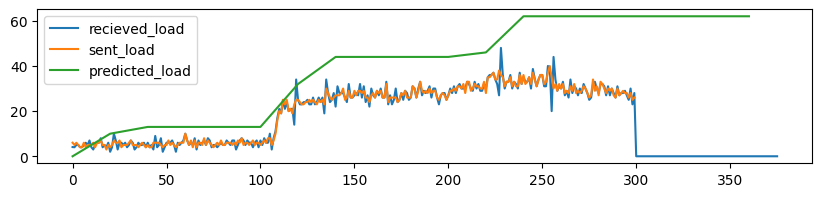

[6, 5, 6, 5, 4, 4, 6, 4, 5, 5, 5, 6, 4, 6, 6, 7, 5, 5, 3, 5, 4, 5, 7, 6, 6, 7, 4, 5, 5, 5, 6, 7, 5, 5, 5, 4, 5, 6, 5, 4, 5, 4, 4, 6, 6, 6, 6, 5, 4, 5, 5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 26, 26, 26, 31, 30, 26, 29, 33, 29, 28, 29, 28, 30, 28, 29, 29, 26, 25, 27, 28, 27, 25, 27, 29, 29, 30, 29, 31, 31, 30, 32, 28, 33, 33, 29, 30, 32, 31, 31, 30, 30, 33, 28, 35, 35, 36, 37, 34, 34, 38, 36, 35, 31, 33, 33, 35, 31, 33, 31, 31, 36, 32, 36, 32, 33, 35, 32, 37, 34, 31, 34, 36, 36, 32, 33, 37, 40, 35, 30, 32, 29, 32, 30, 32, 28, 29, 28, 31, 29, 32, 28, 29, 28, 29, 31, 30, 28, 26, 27

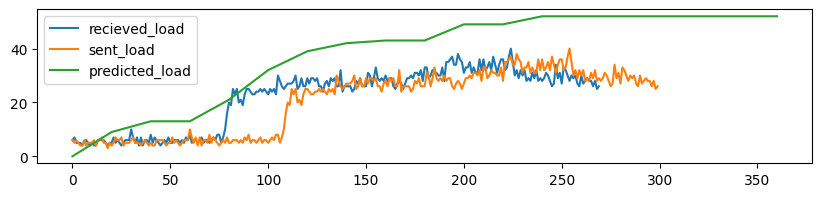

[6, 5, 6, 5, 4, 4, 6, 4, 5, 5, 5, 6, 4, 6, 6, 7, 5, 5, 3, 5, 4, 5, 7, 6, 6, 7, 4, 5, 5, 5, 6, 7, 5, 5, 5, 4, 5, 6, 5, 4, 5, 4, 4, 6, 6, 6, 6, 5, 4, 5, 5, 7, 5, 6, 5, 4, 5, 6, 6, 6, 10, 7, 5, 7, 4, 7, 4, 6, 6, 5, 8, 5, 7, 6, 5, 4, 5, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 6, 8, 5, 6, 6, 5, 6, 7, 5, 6, 6, 5, 6, 7, 6, 8, 8, 5, 7, 10, 16, 20, 19, 25, 23, 25, 20, 21, 19, 23, 25, 25, 24, 23, 23, 24, 24, 25, 24, 25, 24, 23, 25, 24, 25, 23, 30, 28, 26, 25, 26, 27, 27, 27, 28, 30, 25, 26, 29, 26, 26, 29, 27, 29, 29, 28, 29, 26, 26, 24, 27, 28, 26, 29, 28, 29, 26, 26, 32, 24, 26, 26, 26, 26, 24, 25, 28, 27, 29, 26, 26, 26, 31, 30, 26, 29, 33, 29, 28, 29, 28, 30, 28, 29, 29, 26, 25, 27, 28, 27, 25, 27, 29, 29, 30, 29, 31, 31, 30, 32, 28, 33, 33, 29, 30, 32, 31, 31, 30, 30, 33, 28, 35, 35, 36, 37, 34, 34, 38, 36, 35, 31, 33, 33, 35, 31, 33, 31, 31, 36, 32, 36, 32, 33, 35, 32, 37, 34, 31, 34, 36, 36, 32, 33, 37, 40, 35, 30, 32, 29, 32, 30, 32, 28, 29, 28, 31, 29, 32, 28, 29, 28, 29, 31, 30, 28, 26, 27

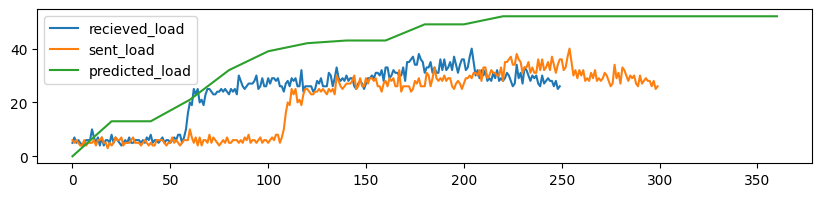

In [9]:
for series, series_dict in series_changes.items():
    recieved_load = series_changes[series]["recieved_load"]
    predicted_load = series_changes[series]["predicted_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    predicted_load_x = series_changes[series]["time_interval"]

    print(sent_loads[series])
    print(recieved_load)

    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_load")
    plt.plot(predicted_load_x, predicted_load, label="predicted_load")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()



    # print(50 * "-" + f" {series} " + 50 * "-")
    # recieved_load = series_changes[series]["recieved_load"]
    # # recieved_load = [int(item) for item in recieved_load if item != 0]
    # recieved_load_x = [x for x in range(0, len(recieved_load))]
    # sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    # print(sent_loads[series])
    # print(recieved_load)

    # print(len(sent_loads[series]))
    # print(len(recieved_load))
    # plt.figure(figsize=(10, 2))
    # plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    # plt.plot(sent_load_x, sent_loads[series], label="sent_workload")
    # # TODO add predicted reference load here
    # plt.legend()
    # plt.show()

## Replica Changes
1. Total
2. Per node

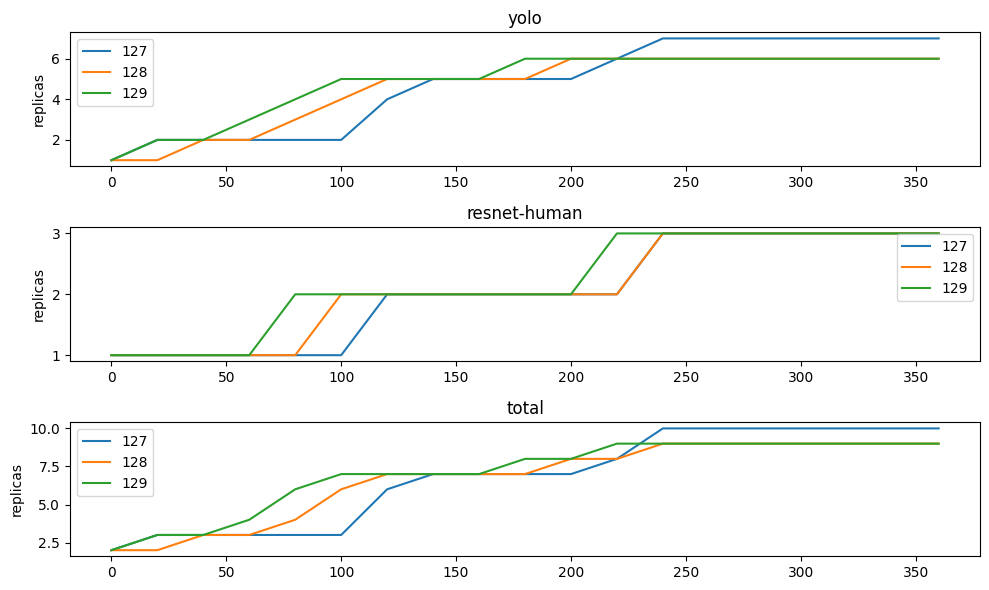

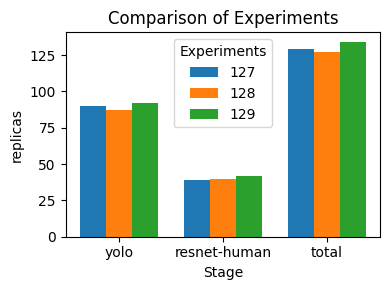

In [10]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [sum(x) for x in zip(*replica_changes[series].values())]
    # draw_temporal(replica_changes[series], adaptation_intervals[series])
ylabel="replicas"
draw_temporal(replica_changes, adaptation_intervals, ylabel=ylabel, multiple_experiments=True)
draw_cumulative(replica_changes, multiple_experiments=True, ylabel=ylabel)

## Per Container Core changes
1. Total
2. Per Node

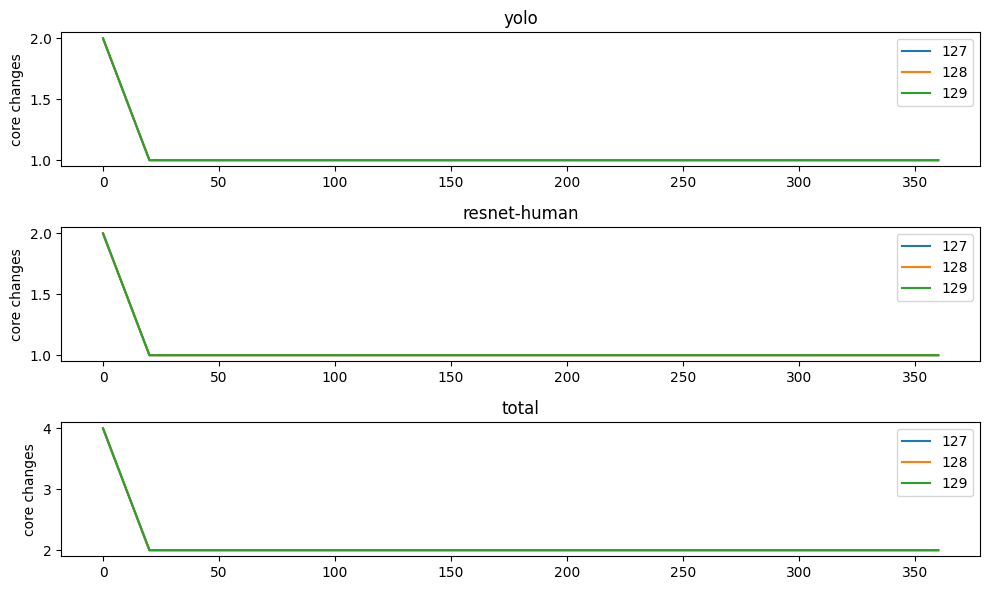

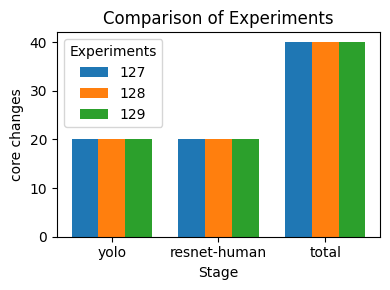

In [11]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [sum(x) for x in zip(*core_changes[series].values())]
    # draw_temporal(core_changes[series])
ylabel="core changes"
draw_temporal(core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
draw_cumulative(core_changes, multiple_experiments=True, ylabel=ylabel)

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

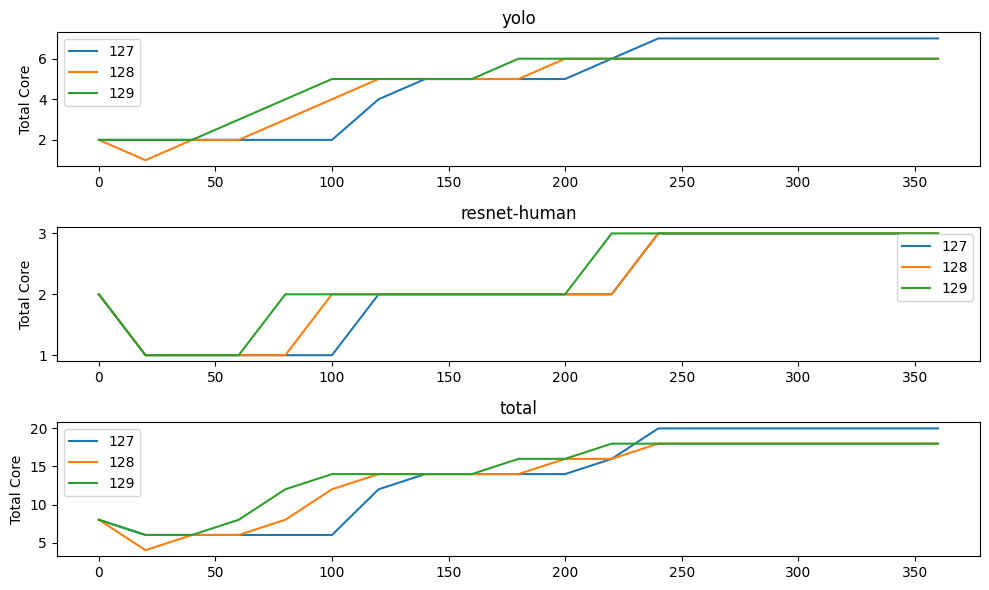

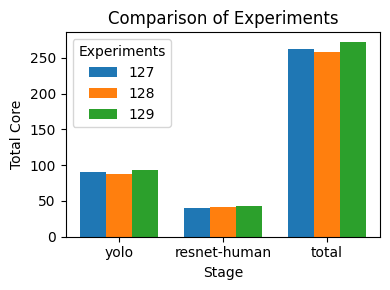

In [12]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        total_core_changes[series][key] = [
            x * y for x, y in zip(replica_changes[series][key], core_changes[series][key])
        ]
    # draw_temporal(total_core_changes[series])
ylabel="Total Core"
draw_temporal(total_core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
draw_cumulative(total_core_changes, multiple_experiments=True, ylabel=ylabel)

## Accuracy Changes

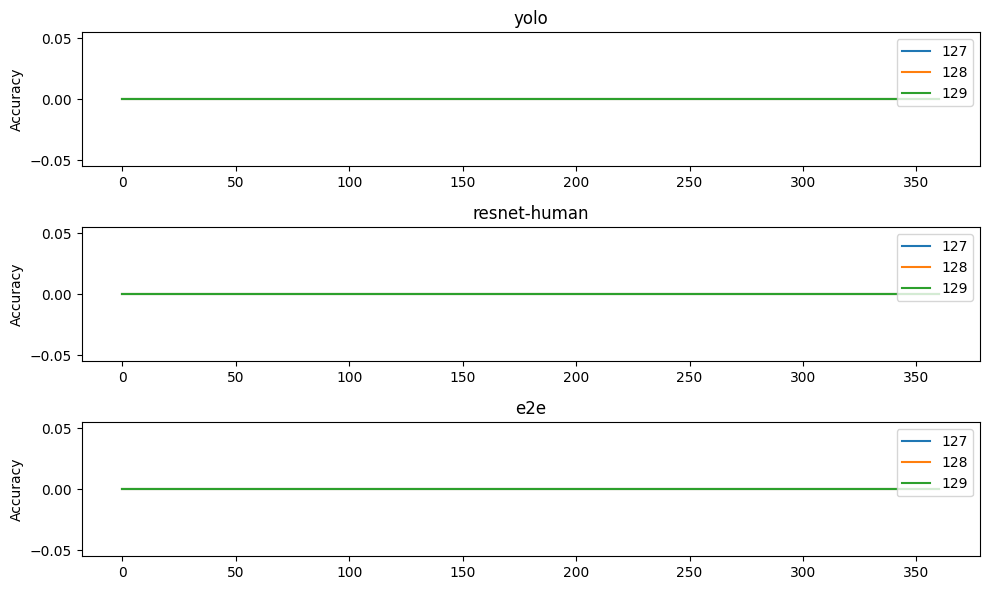

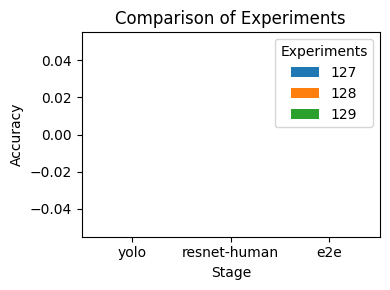

In [13]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [sum(x) for x in zip(*accuracy_changes[series].values())]
    # draw_temporal(accuracy_changes[series])
ylabel="Accuracy"
draw_temporal(accuracy_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
draw_cumulative(accuracy_changes, multiple_experiments=True, ylabel=ylabel)

## Batching Changes

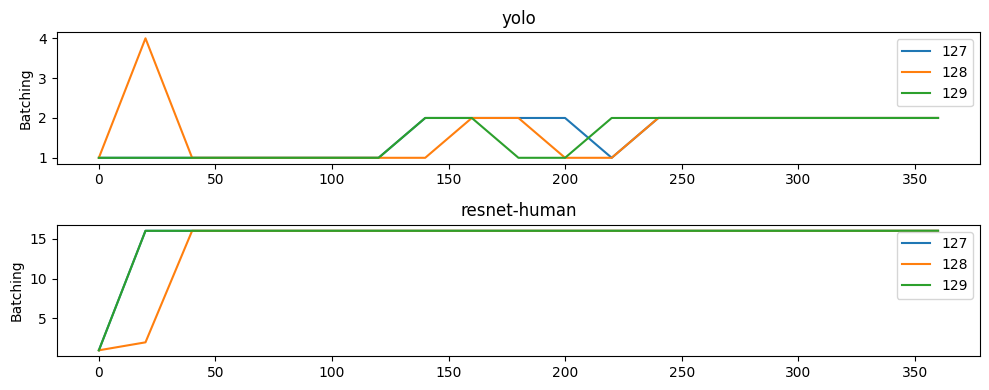

In [14]:
batching_changes = {}
for series in serieses:
    batching_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        batching_changes[series][node_name] = metrics["batch"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    # batching_changes['total'] = [sum(x) for x in zip(*batching_changes.values())]
    # draw_temporal(batching_changes[series])
ylabel = "Batching"
draw_temporal(batching_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
# draw_cumulative(batching_changes, multiple_experiments=True, ylabel=ylabel)

# Expected Throughput

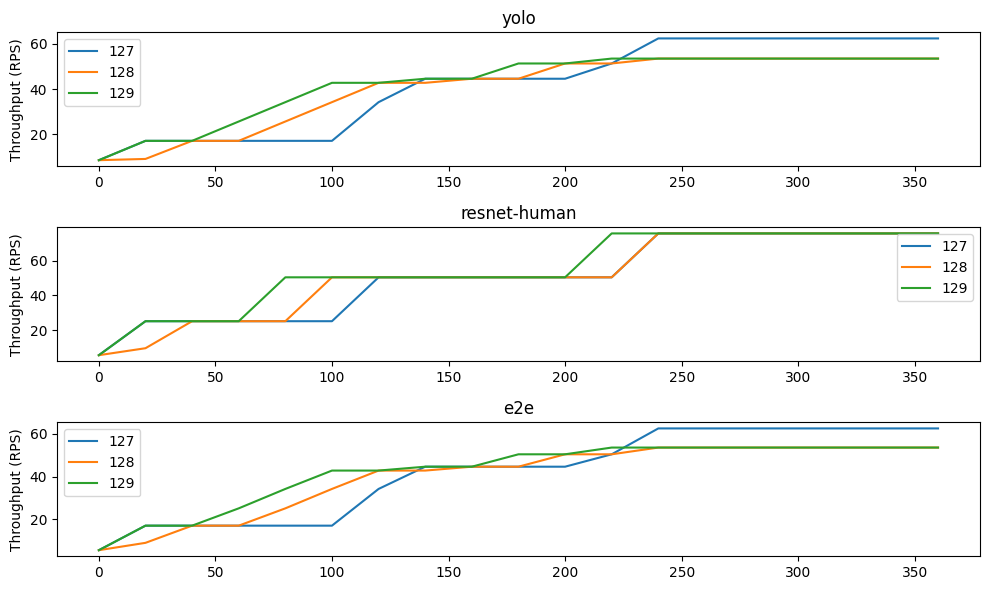

In [15]:
throughput_changes = {}
for series in serieses:
    throughput_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        throughput_changes[series][node_name] = metrics["throughput"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    throughput_changes[series]["e2e"] = [min(x) for x in zip(*throughput_changes[series].values())]
    # draw_temporal(throughput_changes[series])
ylabel = "Throughput (RPS)"
draw_temporal(throughput_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
# draw_cumulative(throughput_changes, multiple_experiments=True, ylabel=ylabel)

## Expected Latency

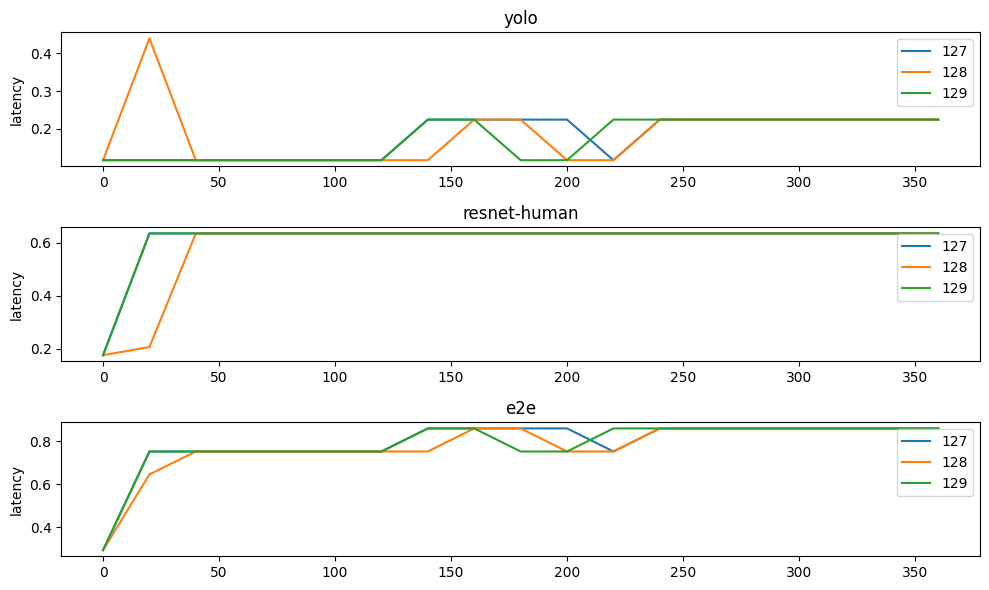

In [16]:
latency_changes = {}
for series in serieses:
    latency_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        latency_changes[series][node_name] = metrics["latency"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    latency_changes[series]["e2e"] = [sum(x) for x in zip(*latency_changes[series].values())]
    # draw_temporal(latency_changes[series])
ylabel = "latency"
draw_temporal(latency_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
# draw_cumulative(latency_changes, multiple_experiments=True, ylabel=ylabel)

# Real Latencies

## Maeseured p99 Latency


In [17]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[series].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

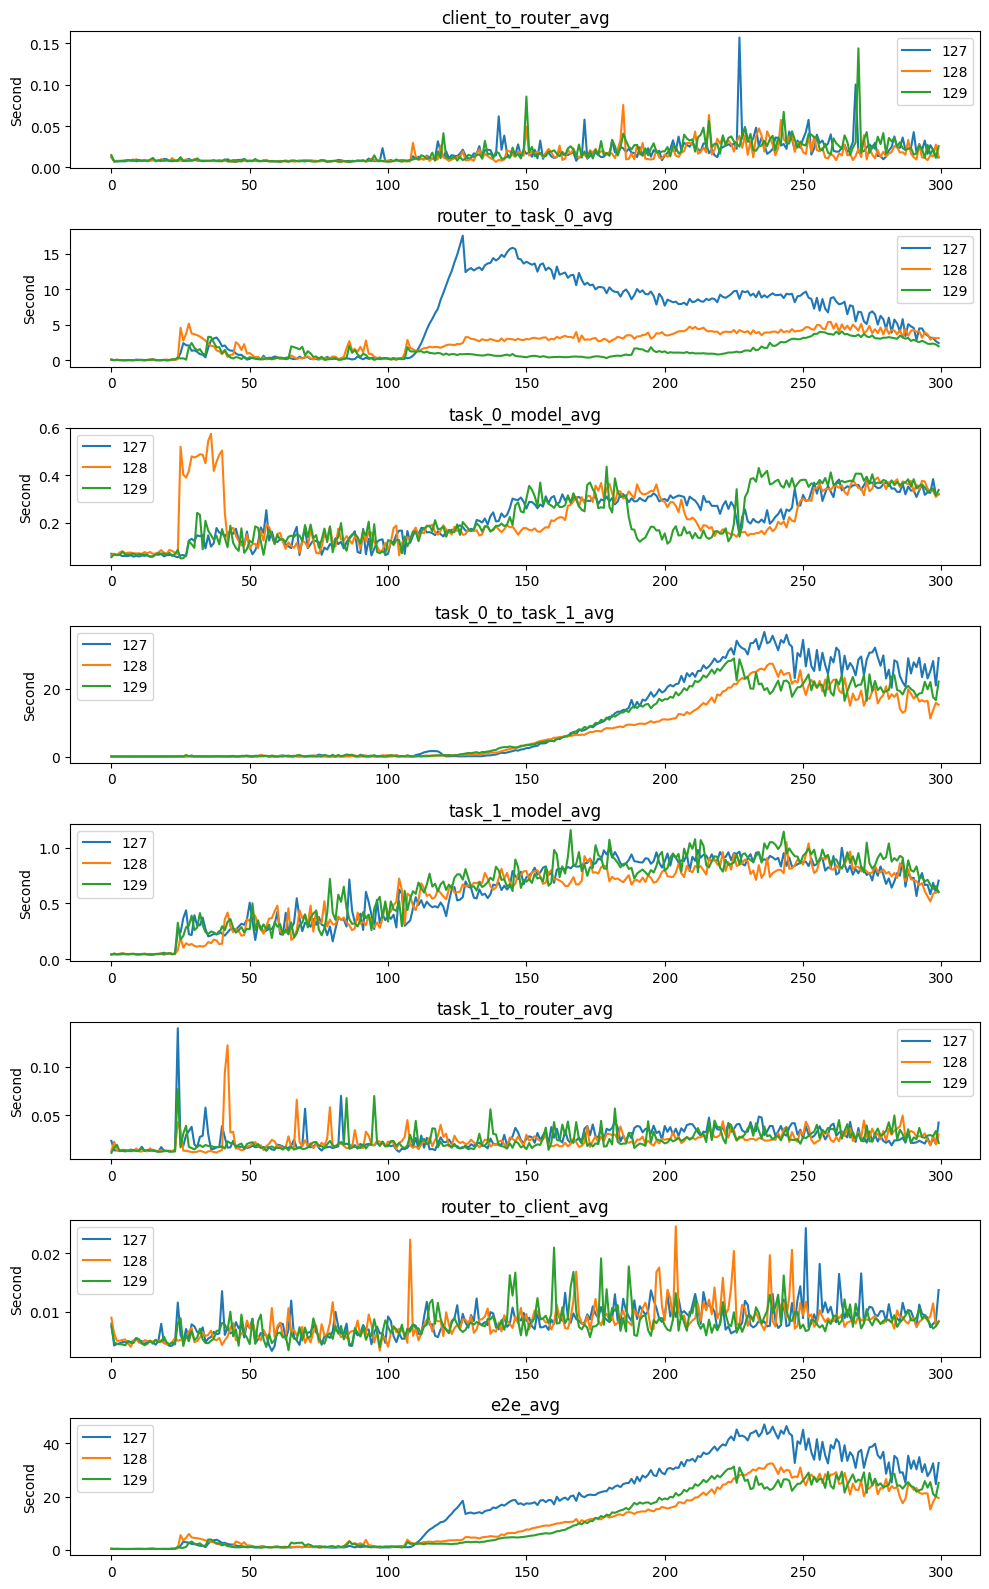

In [18]:
metric = "avg" # [min, max, p99]
metrics_all = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        metric_columns = list(filter(lambda col: metric in col, per_second_results[series].columns))
        metrics_all[series] = per_second_results[series][metric_columns]
        # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
        metrics_all[series] = metrics_all[series].to_dict(orient="list")
        # draw_temporal(metrics_all[series])
ylabel = "Second"
draw_temporal(metrics_all, multiple_experiments=True, ylabel=ylabel)
# draw_cumulative(metrics_all, multiple_experiments=True, ylabel=ylabel)

# Every point a change was triggered

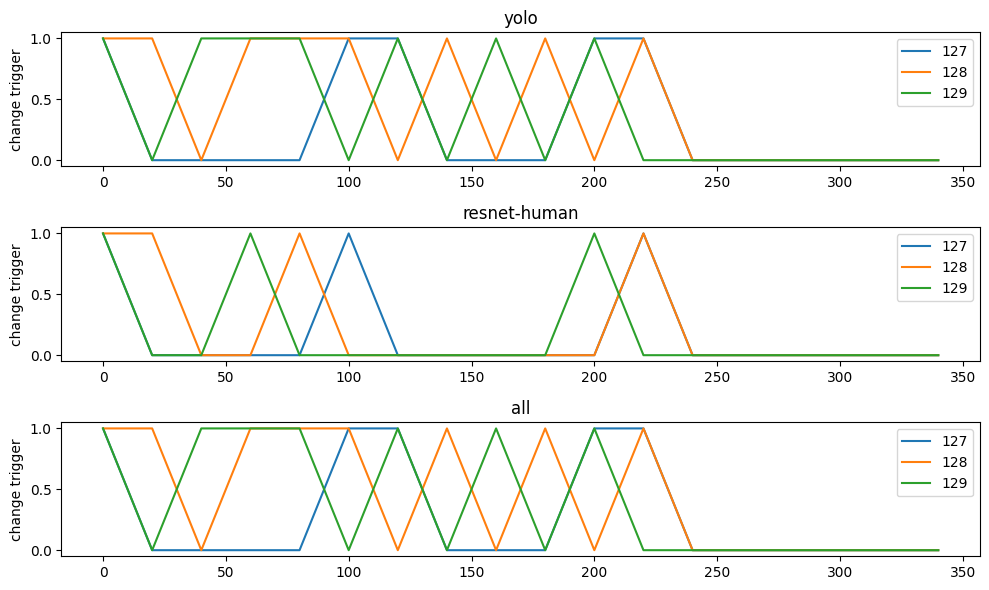

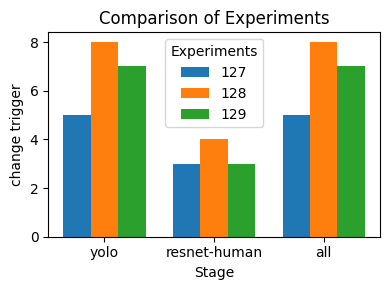

In [19]:
change_trigger = {}
for series in serieses:
    change_trigger[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    change_trigger[series] = loader.points_with_change(adaptation_log=adaptation_logs[series])
    change_trigger[series]["all"] = [any(x) for x in zip(*change_trigger[series].values())]
    # draw_temporal(change_trigger[series], adaptation_interval=adaptation_intervals[series])
ylabel = "change trigger"
draw_temporal(change_trigger, adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
draw_cumulative(change_trigger, multiple_experiments=True, ylabel=ylabel)

# Changes in the objective

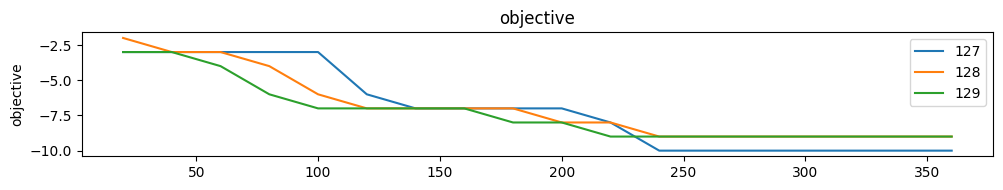

In [20]:
objective_changes = {}
for series in serieses:
    objective_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    objective_changes[series]["objective"] = series_changes[series]["objective"]
    # draw_temporal(objective_changes[series], adaptation_interval=adaptation_intervals[series])
ylabel = "objective"
draw_temporal(objective_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel)
# draw_cumulative(objective_changes, multiple_experiments=True, ylabel=ylabel)

## timeouts

28 out of 6103
2 out of 6103
18 out of 6103


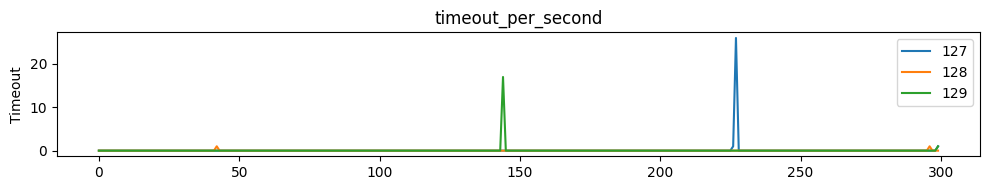

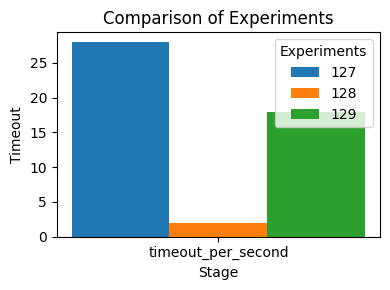

In [21]:
ylabel = "Timeout"
timeout_dics = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        timeout_dics[series] = {"timeout_per_second": timeout_per_second[series]}
        # draw_temporal(timeout_dics[series])
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")
draw_temporal(timeout_dics, multiple_experiments=True, ylabel=ylabel)
draw_cumulative(timeout_dics, multiple_experiments=True, ylabel=ylabel)

In [22]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    for key, value in series_changes[series].items():
        if key == "nodes":
            for node_name, all_configs in value.items():
                print(f"node: {node_name}\n")
                for config_name, config_values in all_configs.items():
                    print(f"{config_name}: {config_values}")

-------------------------------------------------- 127 --------------------------------------------------
node: yolo

cpu: [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
replicas: [1, 2, 2, 2, 2, 2, 4, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7]
batch: [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2]
variant: ['yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n']
latency: [0.11688326750666111, 0.11688326750666111, 0.11688326750666111, 0.11688326750666111, 0.11688326750666111, 0.11688326750666111, 0.11688326750666111, 0.22430964106278584, 0.22430964106278584, 0.22430964106278584, 0.22430964106278584, 0.11688326750666111, 0.22430964106278584, 0.22430964106278584, 0.22430964106278584, 0.22430964106278584, 0.22430964106278584, 0.22430964106278584, 0.22430964106278584]
accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.